# Georgian Digital Alphabet Recognition

### Preprocessing
add useful imports

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

turns a number to a one hot array

In [25]:
def to_one_hot(values: np.ndarray, max: int) -> np.matrix:
    one_hot = np.zeros((values.size, max))
    rows = np.arange(values.size)
    one_hot[rows, values] = 1    

    return one_hot

import image data and convert images to numpy arrays

In [26]:
import matplotlib.image as im

X_arr = list[np.ndarray]()
Y_arr = list[int]()
num_chars = ord("ჰ") - ord("ა") + 1

for i in range(num_chars):
    char = chr(ord("ა") + i)

    file_path = f"data/Letters/{char}"
    for j, image in enumerate(os.listdir(file_path)):
        if j >= 300: break
        img_data = im.imread(f"{file_path}/{image}").ravel()

        X_arr.append(np.append(img_data, np.ones(10000 - len(img_data))))
        Y_arr.append(i)

turn list of image values to numpy matrix, values to one_hot vector

In [27]:
X = np.asmatrix(X_arr)
Y = to_one_hot(np.asarray(Y_arr), num_chars)

X.shape, Y.shape

((9900, 10000), (9900, 33))

divide data to train, validation, and test

In [28]:
division_points = (int(X.shape[0] * 0.6), int(X.shape[0] * 0.8))

data = np.append(X, Y, 1)
np.random.shuffle(data)

X = data[:, 0: X.shape[1]]
Y = data[:, X.shape[1]:]

X_train = X[0: division_points[0], :]
Y_train = Y[0: division_points[0], :]

X_valid = X[division_points[0]: division_points[1], :]
Y_valid = Y[division_points[0]: division_points[1], :]

X_test = X[division_points[1]:, :]
Y_test = Y[division_points[1]:, :]

X_train.shape, X_valid.shape, X_test.shape

((5940, 10000), (1980, 10000), (1980, 10000))

add normalizarion to the three datas seperately

In [29]:
X_train -= X_train.mean(0)
X_valid -= X_valid.mean(0)
X_test -= X_test.mean(0)

##### Reduce dimensions using PCA for data compression reasons
find minimum dimension to reduce data to

In [30]:
min_dimension = 0

sigma = (1 / X_train.shape[0]) * X.T * X
u, s, _ = np.linalg.svd(sigma)

dimension_sum = 0
full_sum = np.sum(s)

for k in range(len(s)):
    dimension_sum += s[k]
    variance_retained = dimension_sum / full_sum

    if variance_retained > 0.99:
        min_dimension = k
        break

In [31]:
min_dimension

775

reduce data

In [32]:
u_reduce = u[:, : min_dimension]

X_train = X_train * u_reduce
X_valid = X_valid * u_reduce
X_test = X_test * u_reduce

X_train.shape, X_valid.shape, X_test.shape

((5940, 775), (1980, 775), (1980, 775))

### Define neural network model class

In [33]:
class NeuralNetworkModel:
    def __init__(self, in_size: int, out_size: int, hidden_sizes: list[int]) -> None:
        self.layers: list[int] = [in_size] + hidden_sizes + [out_size]
        
        self.thetas = list[np.matrix]()
        self.biases = list[np.matrix]()

        for i in range(len(self.layers) - 1):
            prev_size: int = self.layers[i]
            next_size: int = self.layers[i + 1]

            # for large inputs dividing by the sqrt of the size helps to keep weights and layer values low
            self.thetas.append(np.asmatrix(np.random.standard_normal((next_size, prev_size)) / np.sqrt(in_size)))
            self.biases.append(np.asmatrix(np.random.standard_normal((next_size, 1))))

    def __ReLU(self, X: np.matrix) -> np.matrix:
        return np.maximum(0, X)

    def __ReLU_grad(self, X: np.matrix) -> np.matrix:
        return np.where(X <= 0, 0, 1)

    def __sigmoid(self, X: np.matrix) -> np.matrix:
        ephsilon = 1e-5 # to avoid returning 1
        X = X.clip(-500, 500) # to prevent overflows

        return np.divide(1, 1 + np.exp(-X) + ephsilon)

    def __forward(self, input: np.matrix, thetas: list[np.matrix]) -> tuple[np.matrix, list[np.matrix]]:
        result: np.matrix = input
        layer_values: list[np.matrix] = [input]

        for i in range(len(self.layers) - 1):
            # z(i)
            result = np.dot(result, thetas[i].T)
            result = np.add(result, self.biases[i].T)
            # a(i)
            if i != len(self.layers) - 2: 
                result = self.__ReLU(result)
                layer_values.append(result)

            else: result = self.__sigmoid(result)

        return result, layer_values

    # forward propagation, but returns array with only 1 and 0s
    def predict(self, input: np.matrix) -> np.matrix:
        predictions = self.__forward(input, self.thetas)[0]
        return to_one_hot(np.asarray(predictions.argmax(axis=1)).ravel(), num_chars)

    def cost(self, X: np.matrix, Y: np.matrix, lambd: float, thetas: list[np.matrix]) -> float:
        h, _ = self.__forward(X, thetas)

        # compute cost
        first_term = np.multiply(Y, np.log(h))
        second_term = np.multiply((1 - Y), np.log(1 - h))
        J = np.sum(first_term + second_term) / (-X.shape[0])

        # add regularization
        regularized = 0
        for thetas in thetas:
            regularized += np.sum(np.power(thetas, 2)) * (lambd / (2 * X.shape[0]))

        J += regularized

        return J
    
    # backpropagation
    def gradients(self, X: np.matrix, Y: np.matrix, lambd: float) -> tuple[list[np.matrix], list[np.matrix]]:
        m = X.shape[0]

        h, a_values = self.__forward(X, self.thetas)
        bias_a = [np.ones((m, 1)) for _ in a_values]

        grads = [np.zeros(theta.shape) for theta in self.thetas]
        biases = [np.zeros(bias.shape) for bias in self.biases]

        # last layer gradients
        last_delta = h - Y
        grads[-1] = np.dot(last_delta.T, a_values[-1]) / m
        grads[-1] += (lambd * self.thetas[-1]) / m  # regulatization

        biases[-1] = np.dot(last_delta.T, bias_a[-1]) / m

        # hidden layer gradients
        for i in reversed(range(1, len(a_values))):
            delta = np.multiply(np.dot(last_delta, self.thetas[i]), self.__ReLU_grad(a_values[i]))
            last_delta = delta

            grads[i - 1] = np.dot(delta.T, a_values[i - 1]) / m
            grads[i - 1] += (lambd * self.thetas[i - 1]) / m   # regulatization

            biases[i - 1] = np.dot(delta.T, bias_a[i - 1]) / m

        return grads, biases

    #for debugging
    def gradient_check(self, X: np.matrix, Y: np.matrix, lambd: float, grads: list[np.matrix]) -> bool:
        ephsilon = 1e-8
        
        new_theta1 = [np.copy(theta) for theta in self.thetas]
        new_theta2 = [np.copy(theta) for theta in self.thetas]
        preds = [np.zeros(grad.shape) for grad in grads]
        for l in range(len(self.thetas)):
            for i in range(self.thetas[l].shape[0]):
                for j in range(self.thetas[l].shape[1]):
                    new_theta1[l][i, j] = new_theta1[l][i, j] + ephsilon
                    new_theta2[l][i, j] = new_theta2[l][i, j] - ephsilon

                    grad_pred = self.cost(X, Y, lambd, new_theta1) - self.cost(X, Y, lambd, [theta for theta in new_theta2])
                    grad_pred = grad_pred / (2 * ephsilon)
                    preds[l][i, j] = grad_pred

                    new_theta1[l][i, j] = new_theta1[l][i, j] - ephsilon
                    new_theta2[l][i, j] = new_theta2[l][i, j] + ephsilon

        flattened_grads = np.concatenate([np.asarray(grad).ravel() for grad in grads])
        flattened_preds = np.concatenate([np.asarray(pred).ravel() for pred in preds])

        numerator = np.linalg.norm(flattened_grads - flattened_preds)
        denominator = np.linalg.norm(flattened_grads) + np.linalg.norm(flattened_preds)
        diff = numerator / denominator

        if diff > 1e-4:
            print(diff)
            print(grads) 
            print(preds)
            return False

        return True

    def train(self, X: np.matrix, Y: np.matrix, alpha_start: float, lambd: float, max_iters: int = 1000) -> np.ndarray:
        cost = np.zeros(max_iters)

        for i in range(max_iters):
            # learning rate decay
            alpha = alpha_start / np.sqrt(i + 1)

            theta_grads, bias_grads = self.gradients(X, Y, lambd)

            for j, _ in enumerate(self.thetas):
                self.thetas[j] = self.thetas[j] - np.multiply(alpha, theta_grads[j])
                self.biases[j] = self.biases[j] - np.multiply(alpha, bias_grads[j])

            cost[i] = self.cost(X, Y, lambd, self.thetas)

        return cost

    def get_accuracy(self, X: np.matrix, Y: np.matrix) -> float:
        return (self.predict(X) == Y).all(axis=1).mean()

### Build a model

##### draw the graph of model costs to choose the best alpha

In [63]:
hidden_layers = [128, 128]

In [64]:
alpha = 0.3

nn = NeuralNetworkModel(min_dimension, num_chars, hidden_layers)
cost = nn.train(X_train, Y_train, alpha, 0.1, 1000)

Text(0.5, 1.0, 'Error vs. Training Epoch')

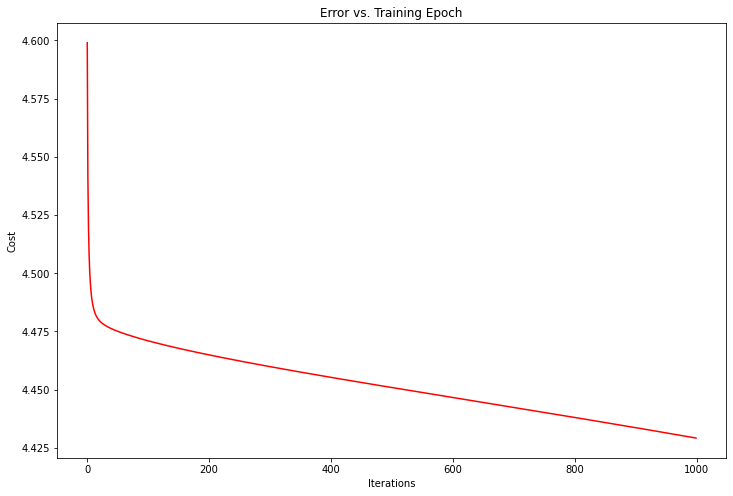

In [65]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(cost.size), cost, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')

##### choose optimal lambda for the model

In [42]:
lambdas: list[float] = [0]

lambd = 0.01
while lambd < 11:
    lambdas.append(lambd)
    
    lambd *= 2

In [44]:
errors_train = np.zeros(len(lambdas))
errors_valid = np.zeros(len(lambdas))
models: list[NeuralNetworkModel] = []

for i, lambd in enumerate(lambdas):
    model = NeuralNetworkModel(min_dimension, num_chars, hidden_layers)
    models.append()
    model.train(X_train, Y_train, alpha, lambd)

    errors_train[i] = 1 - model.get_accuracy(X_train, Y_train)
    errors_valid[i] = 1 - model.get_accuracy(X_valid, Y_valid)

    print(f"{i + 1} / {len(lambdas)}")

In [45]:
lambd = lambdas[errors_valid.argmin()]
model = models[errors_valid.argmin()]
lambd

0.08

Text(0.5, 1.0, 'Error vs. Lambda Value')

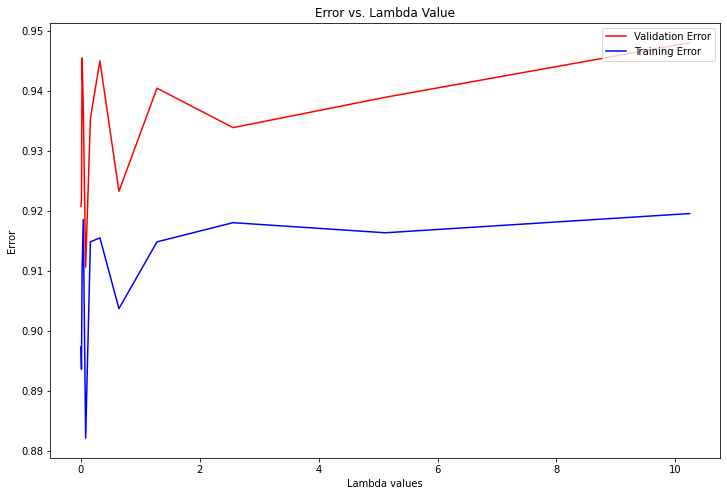

In [46]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.plot(lambdas, errors_valid, 'r', label="Validation Error")
ax.plot(lambdas, errors_train, 'b', label="Training Error")
ax.legend(loc=1)
ax.set_xlabel('Lambda values')
ax.set_ylabel('Error')
ax.set_title('Error vs. Lambda Value')

##### debug model using learning curves

In [47]:
errors_train = np.zeros(10)
errors_valid = np.zeros(10)

for i in range(10):
    X_train_div = X_train[0: int(((i + 1) * X_train.shape[0]) / 10), :]
    Y_train_div = Y_train[0: int(((i + 1) * Y_train.shape[0]) / 10), :]
    X_valid_div = X_valid[0: int(((i + 1) * X_valid.shape[0]) / 10), :]
    Y_valid_div = Y_valid[0: int(((i + 1) * Y_valid.shape[0]) / 10), :]

    model = NeuralNetworkModel(min_dimension, num_chars, hidden_layers)
    model.train(X_train_div, Y_train_div, alpha, lambd)

    errors_train[i] = 1 - model.get_accuracy(X_train_div, Y_train_div)
    errors_valid[i] = 1 - model.get_accuracy(X_valid_div, Y_valid_div)

    print(f"{i + 1} / 10")    

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


Text(0.5, 1.0, 'Error vs. Data Size')

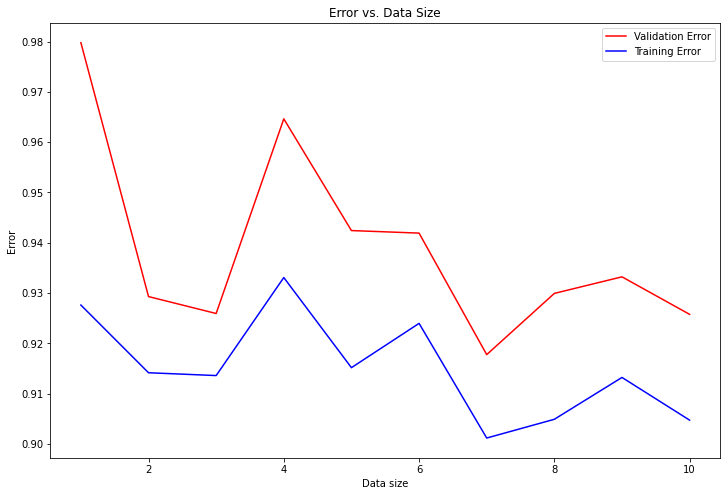

In [48]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(10) + 1, errors_valid, 'r', label="Validation Error")
ax.plot(np.arange(10) + 1, errors_train, 'b', label="Training Error")
ax.legend(loc=1)
ax.set_xlabel('Data size')
ax.set_ylabel('Error')
ax.set_title('Error vs. Data Size')

In [49]:
nn = NeuralNetworkModel(min_dimension, num_chars, hidden_layers)
nn.train(X_train, Y_train, alpha, lambd)

array([9.79041744, 5.45253985, 4.73774377, 4.62734331, 4.57634959,
       4.54748879, 4.52931335, 4.51709685, 4.50850557, 4.50225437,
       4.49758225, 4.49401842, 4.49125204, 4.48907303, 4.487333  ,
       4.48592855, 4.48478042, 4.4838317 , 4.48303957, 4.48237218,
       4.48180445, 4.48131757, 4.48089736, 4.48053129, 4.48020924,
       4.47992329, 4.4796681 , 4.47943862, 4.47923082, 4.47904154,
       4.47886768, 4.47870783, 4.47855955, 4.47842148, 4.47829204,
       4.47817031, 4.47805508, 4.47794566, 4.47784179, 4.47774199,
       4.47764652, 4.47755485, 4.47746664, 4.47738173, 4.47729965,
       4.47721956, 4.47714184, 4.47706583, 4.47699112, 4.47691822,
       4.47684667, 4.4767767 , 4.47670829, 4.47664109, 4.47657527,
       4.47651044, 4.47644631, 4.47638286, 4.47632038, 4.47625877,
       4.47619786, 4.47613763, 4.47607826, 4.4760198 , 4.47596218,
       4.47590532, 4.475849  , 4.47579327, 4.47573794, 4.47568318,
       4.47562903, 4.47557552, 4.47552244, 4.47546966, 4.47541

In [ ]:
whaat = np.asmatrix([
    im.imread(f"data/images/ა/1_aacadhn.ttf_fs_24_bc_256.ა.png").ravel(),
    im.imread(f"data/images/ბ/2648_ashesha.ttf_fs_64_bc_256.ბ.png").ravel(),
    np.zeros(10000)
])

whaat = whaat * u_reduce

In [ ]:
nn.predict(whaat)

In [61]:
nn.get_accuracy(X_test, Y_test)

0.15606060606060607

In [62]:
nn.get_accuracy(X_train, Y_train)

0.1978114478114478